As requested by the organizer, I am releasing the solution that got the highest score on the Public LB. However, I did not select this one as my final solution due to the indirect use of image file size: images are not resized to the same size (left as is), which influences the color histograms. I think similar influences of image size are present in most, if not all, top Public LB solutions.

# PART 1: Detect GenAI images from the GenAI model used for generating the training set

We can identify the images generated by the known GenAI model with high accuracy rather easily. The known GenAI model is the model which generated the images in the training set. Just using a small subsample of the training set (I took 5000 images) gets an acceptable F1 score in minutes.

In [29]:
# Imports
import os
import pickle
import time
import random
from random import choice
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF

import albumentations.core.composition
import albumentations.augmentations as A

from tqdm import tqdm
# from tqdm.notebook import tqdm, tqdm_notebook

import multiprocessing as mp

In [30]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [31]:
# Set seed
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Configure training parameters
BATCH_SIZE = 16
NUM_EPOCHS = 1
LEARNING_RATE = 3e-5
ACCUMULATION_STEPS = 4
RESIZE_SIZE = (256, 256)

In [32]:
# Dataset paths
base_dir = 'dataset'
train_csv_path = os.path.join(base_dir, 'train.csv')
test_csv_path = os.path.join(base_dir, 'test.csv')

print("\nLoading datasets...")

# Load training data
df_train = pd.read_csv(train_csv_path)
df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

# Load test data
df_test = pd.read_csv(test_csv_path)
df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))

# Create train/val split
n_samples_train = min(5000, len(df_train))  # A small subset of training data for faster training
n_samples_val = min(1000, len(df_train) - n_samples_train)

train_data = df_train.iloc[:n_samples_train].copy()
val_data = df_train.iloc[-n_samples_val:].copy()

# Extract paths and labels
train_paths = train_data['file_name'].values
train_labels = train_data['label'].values
internal_val_paths = val_data['file_name'].values
internal_val_labels = val_data['label'].values

# Print dataset statistics
print(f"Train Data: {len(train_paths)}")
print(f"Validation Data: {len(internal_val_paths)}")


Loading datasets...
Train Data: 5000
Validation Data: 1000


Starting model training...



Running validation...
































































































































Training epochs: 100%|██████████| 1/1 [01:52<00:00, 112.45s/it, train_loss=0.2901, val_loss=0.1888, val_f1=0.9259, time=112.5s]


Saving best model with validation F1: 0.9259

Epoch 1/1 completed in 112.5s
Train - Loss: 0.2901, F1: 0.8786, Acc: 0.8726, AUC: 0.9561
Val - Loss: 0.1888, F1: 0.9259, Acc: 0.9270, AUC: 0.9792

Final Training Metrics:
Loss: 0.2901
F1 Score: 0.8786
Accuracy: 0.8726
Precision: 0.8389
Recall: 0.9224
AUC: 0.9561

Final Validation Metrics:
Loss: 0.1888
F1 Score: 0.9259
Accuracy: 0.9270
Precision: 0.9402
Recall: 0.9120
AUC: 0.9792
Generating predictions for 5540 test images...


Processing batches: 100%|██████████| 347/347 [02:03<00:00,  2.81it/s]


Predictions saved to 'submission.csv'

Sample predictions:
                                     id     label
0  1a2d9fd3e21b4266aea1f66b30aed157.jpg  0.585273
1  ab5df8f441fe4fbf9dc9c6baae699dc7.jpg  0.891795
2  eb364dd2dfe34feda0e52466b7ce7956.jpg  0.047988
3  f76c2580e9644d85a741a42c6f6b39c0.jpg  0.012234
4  a16495c578b7494683805484ca27cf9f.jpg  0.200714
5  d08826f7ccab45c8935d8df5524b2869.jpg  0.351086
6  8ba52123cc7b4e3aa90e3947734197e0.jpg  0.004920
7  b107ac0040284f1aace7a6714bf152f7.jpg  0.217970
8  601c646d626d46da8c5fac6653efcfb8.jpg  0.150587
9  ef29ead63754441b82b56c1a22082fdf.jpg  0.403704


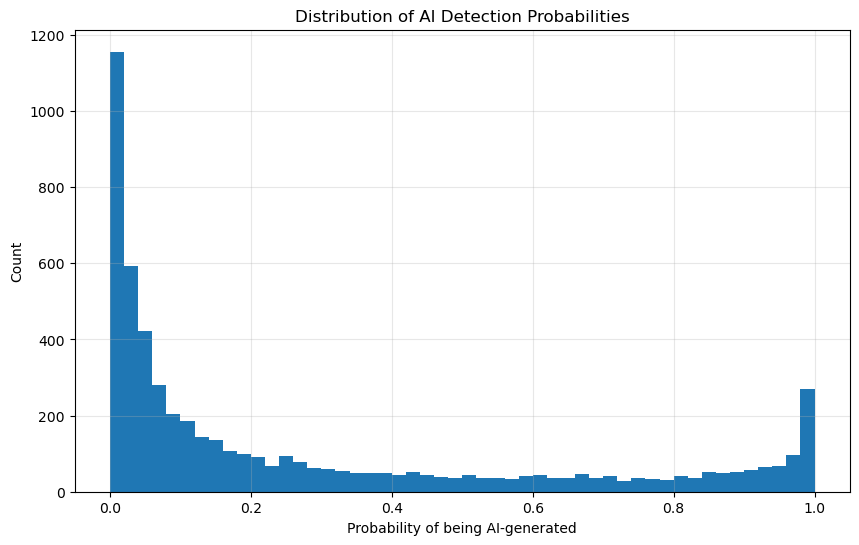

In [ ]:
# Define augmentation functions
def weak_augment(im: Image.Image):
    if random() > 0.5:
        im = TF.jpeg(im, choice([30, 100]))
    if random() > 0.5:
        sigma = 3.0 * random()
        im = TF.gaussian_blur(im, kernel_size=[9, 9], sigma=[sigma, sigma])
    return im

strong_transform = albumentations.core.composition.Compose([
    A.geometric.resize.SmallestMaxSize(max_size=512),
    A.geometric.transforms.HorizontalFlip(p=0.5),
    A.crops.transforms.RandomResizedCrop(height=512, width=512, scale=(0.08, 1.0), ratio=(0.75, 1.0/0.75), p=0.2),
    A.crops.RandomCrop(height=512, width=512),
    A.transforms.ColorJitter(brightness=0.04, contrast=0.04, saturation=0.04, hue=0.1, p=0.8),
    A.transforms.ToGray(p=0.2),
    A.CoarseDropout(max_holes=1, min_holes=1, max_height=96, min_height=96, max_width=96, min_width=96, fill_value=128, p=0.2),
    # A.dropout.CoarseDropout(max_holes=1, min_holes=1, hole_height_range=(96, 96), hole_width_range=(96, 96), fill_value=128, p=0.2),
    A.transforms.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.GaussianBlur()
])

def strong_augment(im: Image.Image):
    im = np.array(im)
    im = strong_transform(image=im)["image"]
    im = Image.fromarray(im)
    return im

# FIRE model: https://github.com/Chuchad/FIRE/tree/main The below version is a much simplified one, without reconstruction.
class FrequencyFilter(nn.Module):
    def __init__(self, radiuslow=40, radiushigh=120):
        super(FrequencyFilter, self).__init__()
        self.radiuslow = radiuslow
        self.radiushigh = radiushigh
        
    def forward(self, image):
        # FFT transform
        freq_image = torch.fft.fftn(image, dim=(-2, -1))
        freq_image = torch.fft.fftshift(freq_image, dim=(-2, -1))
        
        # Create band-pass filters for mid-frequencies
        b, c, h, w = freq_image.shape
        y_grid, x_grid = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
        y_grid = y_grid.to(freq_image.device)
        x_grid = x_grid.to(freq_image.device)
        
        center_y, center_x = h // 2, w // 2
        dist_from_center = torch.sqrt((y_grid - center_y)**2 + (x_grid - center_x)**2)
        
        # Mid-frequency mask
        mid_mask = torch.zeros((h, w), device=freq_image.device)
        mid_mask[(dist_from_center >= self.radiuslow) & (dist_from_center < self.radiushigh)] = 1
        
        # Apply masks
        mid_freq = freq_image * mid_mask.unsqueeze(0).unsqueeze(0)
        
        # Inverse FFT
        mid_freq = torch.fft.ifftshift(mid_freq, dim=(-2, -1))
        mid_freq_spatial = torch.abs(torch.fft.ifftn(mid_freq, dim=(-2, -1)))
        
        # Normalize
        mid_freq_spatial = (mid_freq_spatial - mid_freq_spatial.min() + 1e-8) / (mid_freq_spatial.max() - mid_freq_spatial.min() + 1e-8)
        
        return mid_freq_spatial


class SimplifiedFIRE(nn.Module):
    def __init__(self, pretrained=True):
        super(SimplifiedFIRE, self).__init__()
        # Use a lighter backbone
        self.backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
        
        # Modify for input with 6 channels (3 original + 3 frequency)
        original_weight = self.backbone.conv1.weight.clone()
        self.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Initialize with the pretrained weights, duplicated for additional channels
        if pretrained:
            with torch.no_grad():
                self.backbone.conv1.weight[:, :3] = original_weight
                self.backbone.conv1.weight[:, 3:] = original_weight
        
        # Replace classifier
        self.backbone.fc = nn.Linear(512, 1)
        
        # Frequency transform component
        self.freq_filter = FrequencyFilter(radiuslow=30, radiushigh=100)
        
    def forward(self, x):
        # Get mid-frequency features
        mid_freq_image = self.freq_filter(x)
        
        # Use original image and frequency features
        combined_features = torch.cat([x, mid_freq_image], dim=1)
        
        # Pass through backbone
        out = self.backbone(combined_features)
        
        return out


# Function to convert PIL Image to tensor
def pil_to_tensor(img):
    """Convert PIL Image to normalized tensor."""
    return torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.0


# Calculate and report metrics
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """Calculate and return accuracy, AUC, F1, precision, and recall"""
    y_pred = (np.array(y_pred_proba) > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'auc': auc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


# Apply augmentation to a batch of images
def apply_augmentation(images, augment_type="none"):
    """
    Apply augmentation to a batch of PIL images
    augment_type: "none", "weak", "strong"
    """
    augmented = []
    
    for img in images:
        if augment_type == "weak":
            img = weak_augment(img)
        elif augment_type == "strong":
            img = strong_augment(img)
            
        augmented.append(img)
    
    return augmented


# Function to process images in batches without using DataLoader's multiprocessing
def process_in_batches(model, image_paths, labels=None, batch_size=16, augment_type="none", 
                       resize_size=(256, 256), criterion=None):
    """Process images in batches"""
    is_eval = labels is None or criterion is None
    if not is_eval:
        model.train()
    else:
        model.eval()
    
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_paths = []
    
    # Process in batches
    num_samples = len(image_paths)
    num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division
    
    # Create progress bar
    pbar = tqdm(range(num_batches), desc="Processing batches")
    
    for batch_idx in pbar:
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        
        batch_paths = image_paths[start_idx:end_idx]
        if labels is not None:
            batch_labels = labels[start_idx:end_idx]
        
        # Load images
        batch_images_pil = []
        valid_indices = []
        for i, path in enumerate(batch_paths):
            try:
                img = Image.open(path).convert('RGB')
                img = img.resize(resize_size, Image.LANCZOS)
                batch_images_pil.append(img)
                valid_indices.append(i)
            except Exception as e:
                print(f"Error loading image {path}: {e}")
        
        if not batch_images_pil:
            continue
        
        # Apply augmentation
        augmented_images = apply_augmentation(batch_images_pil, augment_type)
        
        # Convert to tensors
        batch_tensors = [pil_to_tensor(img) for img in augmented_images]
        batch_tensor = torch.stack(batch_tensors).to(device)
        
        if not is_eval:
            batch_label_tensor = torch.tensor([batch_labels[i] for i in valid_indices], 
                                              dtype=torch.float32).to(device)
            
            # Forward pass
            outputs = model(batch_tensor)
            loss = criterion(outputs.squeeze(), batch_label_tensor)
            
            # Backward pass
            loss.backward()
            
            # Track statistics
            running_loss += loss.item() * len(batch_tensor)
            
            all_preds.extend(torch.sigmoid(outputs.squeeze()).detach().cpu().numpy())
            all_labels.extend(batch_label_tensor.cpu().numpy())
            
            # Update progress bar with current loss
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        else:
            with torch.no_grad():
                # Forward pass only
                outputs = model(batch_tensor)
                probs = torch.sigmoid(outputs.squeeze()).cpu().numpy()
                all_preds.extend(probs)
                all_paths.extend([batch_paths[i] for i in valid_indices])
    
    if not is_eval:
        metrics = calculate_metrics(all_labels, all_preds)
        avg_loss = running_loss / len(all_preds) if all_preds else 0
        return avg_loss, metrics, all_preds, all_labels
    else:
        return all_preds, all_paths


# Main training procedure
def train_model_with_augmentation(train_paths, train_labels, val_paths, val_labels,
               batch_size=16, num_epochs=10, learning_rate=1e-4, accumulation_steps=2, augment_type="strong",
               resize_size=(256, 256)):
    
    # Initialize model
    model = SimplifiedFIRE(pretrained=True).to(device)
    
    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    # Track metrics
    best_val_f1 = 0.0
    training_history = {
        'train_loss': [], 'train_acc': [], 'train_auc': [], 'train_f1': [], 'train_precision': [], 'train_recall': [],
        'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': [], 'val_precision': [], 'val_recall': []
    }
    
    # Training loop with progress bar for epochs
    epoch_pbar = tqdm(range(num_epochs), desc="Training epochs")
    
    for epoch in epoch_pbar:
        epoch_start_time = time.time()
        
        # Train - process in mini-batches and update after accumulation_steps
        model.train()
        optimizer.zero_grad()
        
        # Split train data into smaller chunks to avoid memory issues
        chunk_size = 200  # Process training data in chunks
        num_chunks = (len(train_paths) + chunk_size - 1) // chunk_size
        
        all_train_preds = []
        all_train_labels = []
        train_loss_sum = 0
        train_samples = 0
        
        # Create a progress bar for chunks
        chunk_pbar = tqdm(range(num_chunks), desc=f"Epoch {epoch+1} chunks")
        
        for chunk in chunk_pbar:
            start_idx = chunk * chunk_size
            end_idx = min((chunk + 1) * chunk_size, len(train_paths))
            
            chunk_paths = train_paths[start_idx:end_idx]
            chunk_labels = train_labels[start_idx:end_idx]
            
            # Process chunk in batches with its own progress bar
            batch_pbar = tqdm(range(0, len(chunk_paths), batch_size), 
                             desc=f"Chunk {chunk+1}/{num_chunks}", 
                             leave=False)
            
            for b_idx in batch_pbar:
                b_end = min(b_idx + batch_size, len(chunk_paths))
                batch_paths = chunk_paths[b_idx:b_end]
                batch_labels = chunk_labels[b_idx:b_end]
                
                # Load images
                batch_images_pil = []
                batch_label_list = []
                
                for i, path in enumerate(batch_paths):
                    try:
                        img = Image.open(path).convert('RGB')
                        img = img.resize(resize_size, Image.LANCZOS)
                        batch_images_pil.append(img)
                        batch_label_list.append(batch_labels[i])
                    except Exception as e:
                        print(f"Error loading image {path}: {e}")
                
                if not batch_images_pil:
                    continue
                
                # Apply augmentation
                augmented_images = apply_augmentation(batch_images_pil, augment_type)
                
                # Convert to tensors
                batch_tensors = [pil_to_tensor(img) for img in augmented_images]
                batch_tensor = torch.stack(batch_tensors).to(device)
                batch_labels_tensor = torch.tensor(batch_label_list, dtype=torch.float32).to(device)
                
                # Forward pass with mixed precision
                with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = model(batch_tensor)
                    loss = criterion(outputs.squeeze(), batch_labels_tensor)
                    loss = loss / accumulation_steps
                
                # Backward pass
                loss.backward()
                
                # Update weights if needed
                if ((b_idx + batch_size) % (batch_size * accumulation_steps) == 0 or 
                    (chunk == num_chunks - 1 and b_end == len(chunk_paths))):
                    optimizer.step()
                    optimizer.zero_grad()
                
                # Get predictions
                probs = torch.sigmoid(outputs.squeeze()).detach().cpu().numpy()
                all_train_preds.extend(probs)
                all_train_labels.extend(batch_labels_tensor.cpu().numpy())
                
                # Update statistics
                train_loss_sum += loss.item() * accumulation_steps * len(batch_tensor)
                train_samples += len(batch_tensor)
                
                # Update batch progress bar with current loss
                batch_pbar.set_postfix({'loss': f"{loss.item() * accumulation_steps:.4f}"})
            
            # Update chunk progress bar with average loss so far
            chunk_pbar.set_postfix({
                'avg_loss': f"{train_loss_sum / train_samples if train_samples > 0 else 0:.4f}"
            })
        
        # Calculate training metrics
        train_loss = train_loss_sum / train_samples if train_samples > 0 else 0
        train_metrics = calculate_metrics(all_train_labels, all_train_preds)
        
        # Validate - No augmentation for validation
        print("\nRunning validation...")
        model.eval()
        val_loss, val_metrics, val_preds, val_labels = process_in_batches(
            model, val_paths, val_labels, batch_size, augment_type="none", resize_size=resize_size, criterion=criterion)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save metrics
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_metrics['accuracy'])
        training_history['train_auc'].append(train_metrics['auc'])
        training_history['train_f1'].append(train_metrics['f1'])
        training_history['train_precision'].append(train_metrics['precision'])
        training_history['train_recall'].append(train_metrics['recall'])
        
        training_history['val_loss'].append(val_loss)
        training_history['val_acc'].append(val_metrics['accuracy'])
        training_history['val_auc'].append(val_metrics['auc'])
        training_history['val_f1'].append(val_metrics['f1'])
        training_history['val_precision'].append(val_metrics['precision'])
        training_history['val_recall'].append(val_metrics['recall'])
        
        # Save best model based on F1 score
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            print(f"Saving best model with validation F1: {val_metrics['f1']:.4f}")
            torch.save(model.state_dict(), '../../trained_models/image_simplified_fire_model_2_best.pth')
            
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Update epoch progress bar with metrics
        epoch_pbar.set_postfix({
            'train_loss': f"{train_loss:.4f}",
            'val_loss': f"{val_loss:.4f}",
            'val_f1': f"{val_metrics['f1']:.4f}",
            'time': f"{epoch_time:.1f}s"
        })
        
        # Print detailed metrics at the end of each epoch
        print(f"\nEpoch {epoch+1}/{num_epochs} completed in {epoch_time:.1f}s")
        print(f"Train - Loss: {train_loss:.4f}, F1: {train_metrics['f1']:.4f}, "
              f"Acc: {train_metrics['accuracy']:.4f}, AUC: {train_metrics['auc']:.4f}")
        print(f"Val - Loss: {val_loss:.4f}, F1: {val_metrics['f1']:.4f}, "
              f"Acc: {val_metrics['accuracy']:.4f}, AUC: {val_metrics['auc']:.4f}")
    
    # Save final model
    torch.save(model.state_dict(), '../../trained_models/image_simplified_fire_model_2_final.pth')
    
    return model, training_history


print("Starting model training...")
model, history = train_model_with_augmentation(
    train_paths=train_paths,
    train_labels=train_labels,
    val_paths=internal_val_paths,
    val_labels=internal_val_labels,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    accumulation_steps=ACCUMULATION_STEPS,
    augment_type="strong",
    resize_size=RESIZE_SIZE
)

In [38]:
# Report final metrics
print("\nFinal Training Metrics:")
print(f"Loss: {history['train_loss'][-1]:.4f}")
print(f"F1 Score: {history['train_f1'][-1]:.4f}")
print(f"Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Precision: {history['train_precision'][-1]:.4f}")
print(f"Recall: {history['train_recall'][-1]:.4f}")
print(f"AUC: {history['train_auc'][-1]:.4f}")

print("\nFinal Validation Metrics:")
print(f"Loss: {history['val_loss'][-1]:.4f}")
print(f"F1 Score: {history['val_f1'][-1]:.4f}")
print(f"Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Precision: {history['val_precision'][-1]:.4f}")
print(f"Recall: {history['val_recall'][-1]:.4f}")
print(f"AUC: {history['val_auc'][-1]:.4f}")


Final Training Metrics:
Loss: 0.2901
F1 Score: 0.8786
Accuracy: 0.8726
Precision: 0.8389
Recall: 0.9224
AUC: 0.9561

Final Validation Metrics:
Loss: 0.1888
F1 Score: 0.9259
Accuracy: 0.9270
Precision: 0.9402
Recall: 0.9120
AUC: 0.9792


In [ ]:
model.eval()

# Extract test paths
test_paths = df_test['id'].values
print(f"Generating predictions for {len(test_paths)} test images...")

# Generate predictions using the safe prediction function
# This function returns probability predictions (values between 0 and 1)
predictions_proba, processed_paths = process_in_batches(
    model,
    test_paths,
    labels=None,
    batch_size=BATCH_SIZE,
    augment_type="none",  # No augmentation for test predictions
    resize_size=RESIZE_SIZE  # Same size as used in training
)

# Create DataFrame with probabilities and save it (keeping the probability output)
results_proba = pd.DataFrame({
    'id': [("test_data_v2/" + os.path.basename(path)) for path in processed_paths],
    'label': predictions_proba # These are the probabilities
})
results_proba.to_csv('pred_probabilities.csv', index=False)
print("\nProbability predictions saved to 'pred_probabilities.csv'")

# --- Convert probabilities to binary predictions ---

# Apply the 0.5 threshold to get binary predictions (0 or 1)
predictions_binary = (np.array(predictions_proba) >= 0.5).astype(int)

# Create a new DataFrame with the binary predictions
results_binary = pd.DataFrame({
    'id': [("test_data_v2/" + os.path.basename(path)) for path in processed_paths],
    'label': predictions_binary # These are the binary labels (0 or 1)
})

# Save the binary results to a submission CSV file
results_binary.to_csv('submission.csv', index=False)
print("Binary predictions saved to 'submission.csv'")

# Show sample binary predictions
print("\nSample binary predictions (submission format):")
print(results_binary.head(10))

# Visualize prediction distribution (still useful to see probability spread)
# This plot should ideally use the probabilities, not the binary results.
print("\nVisualizing probability distribution...")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Use the original probabilities for the histogram visualization
plt.hist(results_proba['label'], bins=50)
plt.title('Distribution of AI Detection Probabilities')
plt.xlabel('Probability of being AI-generated')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.savefig('prediction_distribution.png')
plt.show()

Generating predictions for 5540 test images...


Processing batches: 100%|██████████| 347/347 [01:57<00:00,  2.96it/s]


TypeError: can only concatenate str (not "list") to str

# PART 2: Detect unknown GenAI images

The idea is to find anomalies in 3D color histogram mean value by comparing a sample of real images from the training set vs the test set images of mixed real and unknown GenAI model generations. This, however, is influenced by the image size because higher size images will have a higher color histogram mean value.

In [ ]:
df_train = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv', index_col=0)
df_train['full_path'] = '/kaggle/input/ai-vs-human-generated-dataset/' + df_train['file_name']
df_train.head(3)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ai-vs-human-generated-dataset/train.csv'

In [ ]:
df_train_real_imgs = df_train[df_train['label'] == 0].copy()
df_train_ai_imgs = df_train[df_train['label'] == 1].copy()

Processing real images:   0%|          | 0/5544 [00:00<?, ?image/s]

Processing mixed real and GenAI images:   0%|          | 0/5332 [00:00<?, ?image/s]

Highest peak in real images found at: 0.023405
Lower bound (0.5th percentile): 0.010986
Upper bound (99.5th percentile): 0.035156
Delta value needed around peak to capture 99.0% of real images: ±0.012418
Adjusted lower threshold: 0.010986
Adjusted upper threshold: 0.035823
Real images within range: 5529 (99.73%)


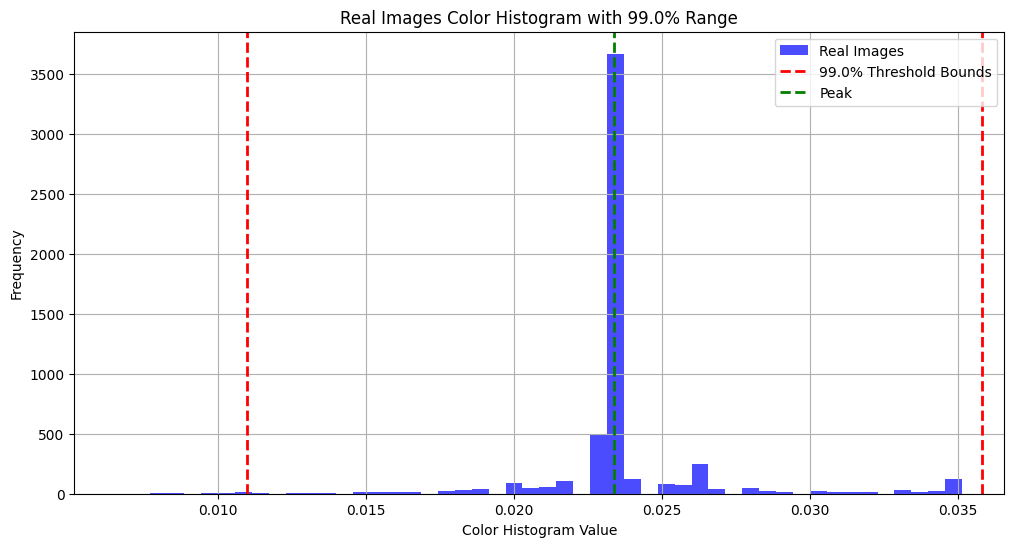

Highest peak in mixed images found at: 0.039801
Mixed images lower threshold: 0.027383
Mixed images upper threshold: 0.052219
Mixed images within peak range: 2658 (49.85%)
Mixed images outside peak range: 2674 (50.15%)


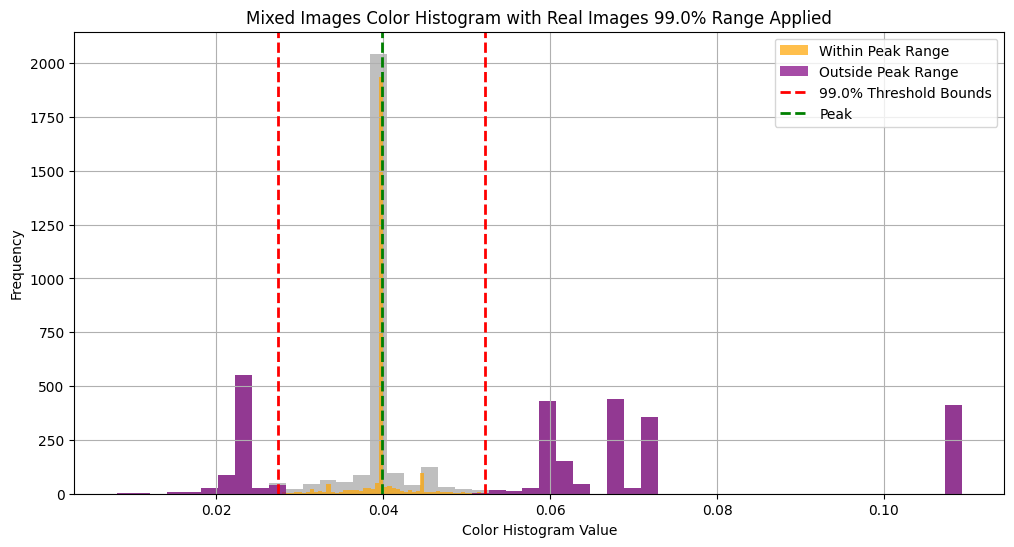

In [ ]:
def compute_color_histogram(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Calculate the color histogram (flattened and mean computed)
    hist = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    return hist.flatten().mean()

def process_image(row):
    image_path = row['full_path']
    hist_value = compute_color_histogram(image_path)
    return hist_value

sample_size = 5544
real_samples = df_train_real_imgs.sample(sample_size, random_state=60)

with mp.Pool(processes=4) as pool:
    real_histogram_values = list(tqdm(
        pool.imap(process_image, [row for _, row in real_samples.iterrows()]),
        total=real_samples.shape[0],
        desc="Processing real images",
        unit="image"
    ))

# Load the predicted probabilities for known GenAI images
predicted_probs = pd.read_csv('/kaggle/working/pred_probabilities.csv')

pred_labels = predicted_probs.copy()
pred_labels['full_path'] = '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/' + pred_labels['id']
m = predicted_probs['label'] > 0.99
pred_labels.loc[m, 'label'] = 1  # GenAI model generated images
pred_labels.loc[~m, 'label'] = -1  # Mixed real and unknown GenAI model images

negative_label_images = pred_labels[pred_labels['label'] == -1].copy()

# Process mixed real and GenAI images from the test set
with mp.Pool(processes=4) as pool:
    histogram_values = list(tqdm(
        pool.imap(process_image, [row for _, row in negative_label_images.iterrows()]),
        total=negative_label_images.shape[0],
        desc="Processing mixed real and GenAI images",
        unit="image"
    ))

# Define confidence level (e.g., 99%)
confidence_percent = 99.0

# Find the peak in real_histogram_values and determine the range for the specified confidence level
# Find the peak in real_histogram_values using kernel density estimation
kde_real = stats.gaussian_kde(real_histogram_values)
x_vals_real = np.linspace(min(real_histogram_values), max(real_histogram_values), 1000)
y_vals_real = kde_real(x_vals_real)
peak_x_real = x_vals_real[np.argmax(y_vals_real)]
print(f"Highest peak in real images found at: {peak_x_real:.6f}")

# Calculate the percentiles to capture the specified confidence level
lower_percentile = (100 - confidence_percent) / 2
upper_percentile = 100 - lower_percentile
lower_percentile_real = np.percentile(real_histogram_values, lower_percentile)
upper_percentile_real = np.percentile(real_histogram_values, upper_percentile)
print(f"Lower bound ({lower_percentile:.1f}th percentile): {lower_percentile_real:.6f}")
print(f"Upper bound ({upper_percentile:.1f}th percentile): {upper_percentile_real:.6f}")

# Calculate the +/- value from the peak that would capture the specified confidence level of real images
delta_value = max(abs(peak_x_real - lower_percentile_real), abs(upper_percentile_real - peak_x_real))
print(f"Delta value needed around peak to capture {confidence_percent}% of real images: ±{delta_value:.6f}")

# Set thresholds using this delta
lower_threshold_real = peak_x_real - delta_value
upper_threshold_real = peak_x_real + delta_value
print(f"Adjusted lower threshold: {lower_threshold_real:.6f}")
print(f"Adjusted upper threshold: {upper_threshold_real:.6f}")

# Count how many real images actually fall within this range
real_in_range_count = sum(lower_threshold_real <= val <= upper_threshold_real for val in real_histogram_values)
real_in_range_percentage = real_in_range_count / len(real_histogram_values) * 100
print(f"Real images within range: {real_in_range_count} ({real_in_range_percentage:.2f}%)")

# Plot the real images histogram with threshold lines
plt.figure(figsize=(12, 6))
plt.hist(real_histogram_values, bins=50, alpha=0.7, color='blue', label='Real Images')
plt.axvline(lower_threshold_real, color='red', linestyle='dashed', linewidth=2, label=f'{confidence_percent}% Threshold Bounds')
plt.axvline(upper_threshold_real, color='red', linestyle='dashed', linewidth=2)
plt.axvline(peak_x_real, color='green', linestyle='dashed', linewidth=2, label='Peak')
plt.title(f'Real Images Color Histogram with {confidence_percent}% Range')
plt.xlabel('Color Histogram Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Find the peak in histogram_values (mixed images) and apply the same +/- delta
# Find the peak in mixed images
kde_mixed = stats.gaussian_kde(histogram_values)
x_vals_mixed = np.linspace(min(histogram_values), max(histogram_values), 1000)
y_vals_mixed = kde_mixed(x_vals_mixed)
peak_x_mixed = x_vals_mixed[np.argmax(y_vals_mixed)]
print(f"Highest peak in mixed images found at: {peak_x_mixed:.6f}")

# Apply the same delta value from real images
lower_threshold_mixed = peak_x_mixed - delta_value
upper_threshold_mixed = peak_x_mixed + delta_value
print(f"Mixed images lower threshold: {lower_threshold_mixed:.6f}")
print(f"Mixed images upper threshold: {upper_threshold_mixed:.6f}")

# Classify mixed images based on thresholds
classifications = np.zeros(len(histogram_values))
for i, value in enumerate(histogram_values):
    if lower_threshold_mixed <= value <= upper_threshold_mixed:
        classifications[i] = 0  # Values within the range
    else:
        classifications[i] = 1  # Values outside the range

# Count results for mixed images
in_range_count = np.sum(classifications == 0)
out_range_count = np.sum(classifications == 1)
print(f"Mixed images within peak range: {in_range_count} ({in_range_count/len(classifications)*100:.2f}%)")
print(f"Mixed images outside peak range: {out_range_count} ({out_range_count/len(classifications)*100:.2f}%)")

# Add classifications to dataframe
negative_label_images.loc[:, 'peak_class'] = classifications

# Plot the mixed images histogram with the same delta threshold as real images
plt.figure(figsize=(12, 6))
plt.hist(histogram_values, bins=50, alpha=0.5, color='gray')
plt.hist([v for i, v in enumerate(histogram_values) if classifications[i] == 0], 
         bins=50, alpha=0.7, color='orange', label='Within Peak Range')
plt.hist([v for i, v in enumerate(histogram_values) if classifications[i] == 1], 
         bins=50, alpha=0.7, color='purple', label='Outside Peak Range')
plt.axvline(lower_threshold_mixed, color='red', linestyle='dashed', linewidth=2, label=f'{confidence_percent}% Threshold Bounds')
plt.axvline(upper_threshold_mixed, color='red', linestyle='dashed', linewidth=2)
plt.axvline(peak_x_mixed, color='green', linestyle='dashed', linewidth=2, label='Peak')
plt.title(f'Mixed Images Color Histogram with Real Images {confidence_percent}% Range Applied')
plt.xlabel('Color Histogram Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

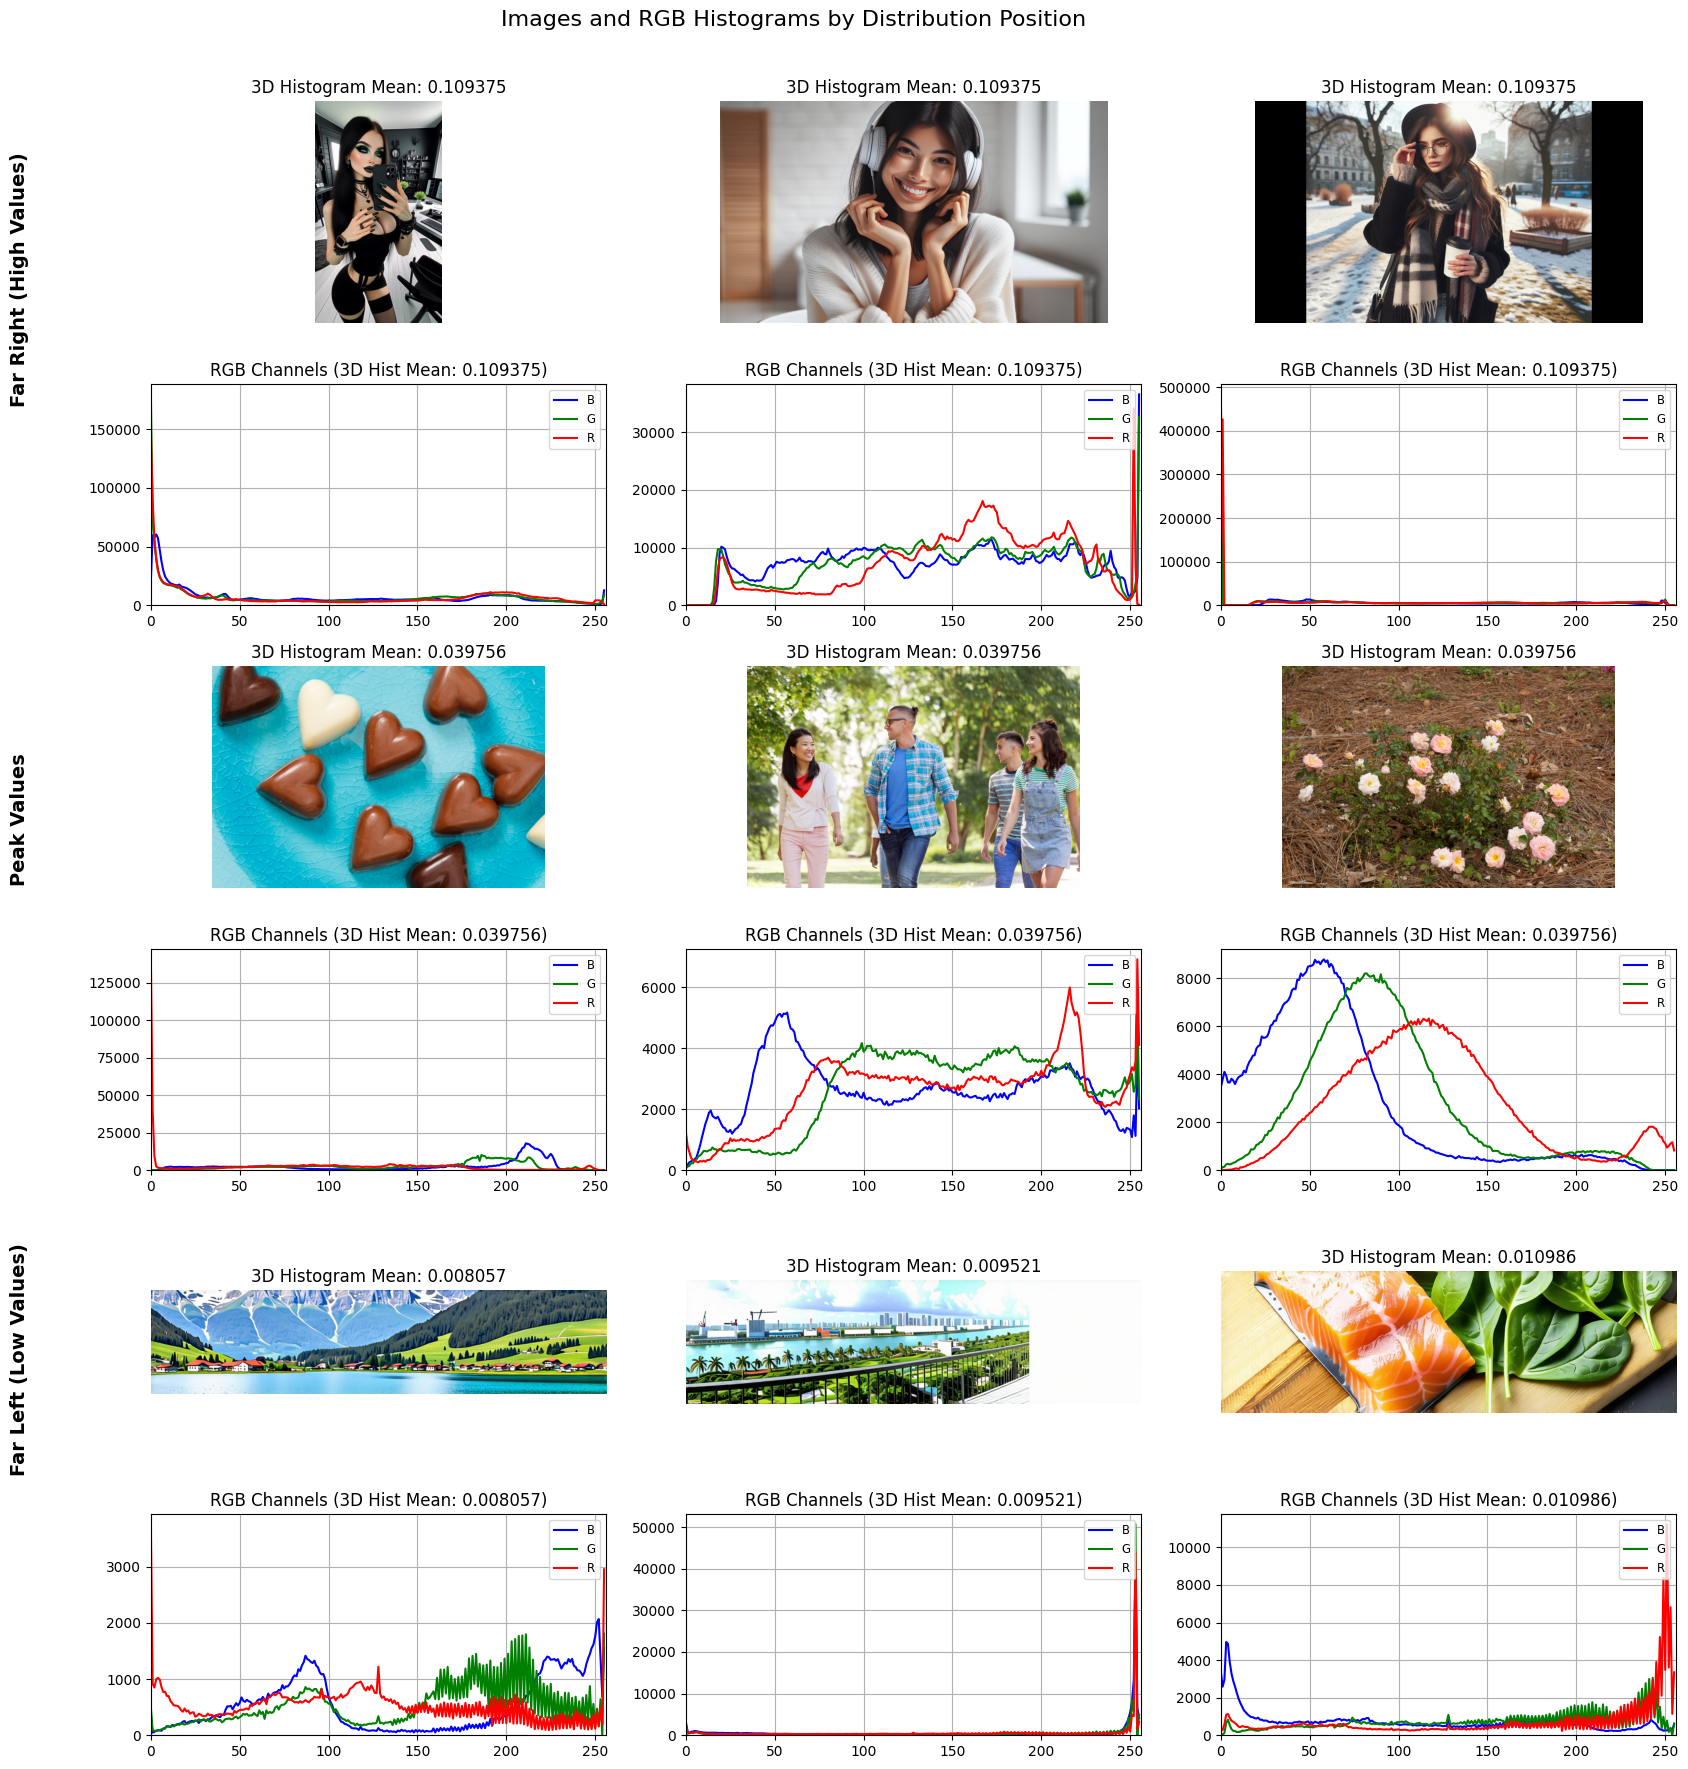

In [ ]:
# Function to read image and compute color histogram mean using 3D histogram
def compute_color_histogram(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return None, None, None
    
    # Convert BGR to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate histograms for each channel (for visualization)
    hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])
    
    # Calculate the 3D color histogram and its mean as in the original code
    full_hist = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    mean_value = full_hist.flatten().mean()
    
    return image_rgb, (hist_b, hist_g, hist_r), mean_value

# Function to get n indices from a sorted array based on different criteria
def get_extreme_indices(values, n, from_end='left'):
    # Sort the values
    sorted_indices = np.argsort(values)
    
    if from_end == 'left':
        # Get n indices from the start (lowest values)
        selected_indices = sorted_indices[:n]
    elif from_end == 'right':
        # Get n indices from the end (highest values)
        selected_indices = sorted_indices[-n:]
    elif from_end == 'peak':
        # Get indices closest to the peak (using median value)
        peak_value = np.median(values)
        peak_diff = np.abs(np.array(values) - peak_value)
        selected_indices = np.argsort(peak_diff)[:n]
    
    return selected_indices

# Get 3 examples from each area of the distribution
n_examples = 3
left_extreme_indices = get_extreme_indices(histogram_values, n_examples, from_end='left')
peak_indices = get_extreme_indices(histogram_values, n_examples, from_end='peak')
right_extreme_indices = get_extreme_indices(histogram_values, n_examples, from_end='right')

# Create a figure with 3 rows (left, peak, right) x 3 columns (3 examples each)
fig = plt.figure(figsize=(18, 18))

# Define row titles in new order (far right first, peak in middle, far left last)
row_titles = ["Far Right (High Values)", "Peak Values", "Far Left (Low Values)"]

# Define the sets of indices to use for each row in the new order
all_indices = [right_extreme_indices, peak_indices, left_extreme_indices]

# Create the grid of images and histograms
for row in range(3):
    # Add row title to the left of the first image in each row
    fig.text(0.07, 0.83 - row * 0.3, row_titles[row], 
             fontsize=14, fontweight='bold', ha='center', va='center',
             rotation=90)
             
    for col in range(3):
        # Get index for this grid position
        img_idx = all_indices[row][col]
        
        # Get image path and histogram value
        image_path = negative_label_images.iloc[img_idx]['full_path']
        hist_value = histogram_values[img_idx]
        
        # Load the image and get its histograms
        image, channel_hists, mean_value = compute_color_histogram(image_path)
        
        # Position for image
        ax_img = plt.subplot2grid((6, 9), (2*row, 3*col), colspan=3, rowspan=1)
        
        if image is None:
            ax_img.text(0.5, 0.5, "Image not found", ha='center', va='center')
            continue
        
        # Display the image
        ax_img.imshow(image)
        ax_img.set_title(f"3D Histogram Mean: {hist_value:.6f}")
        ax_img.axis('off')
        
        # Position for histogram
        ax_hist = plt.subplot2grid((6, 9), (2*row+1, 3*col), colspan=3, rowspan=1)
        
        # Plot channel histograms
        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            ax_hist.plot(channel_hists[i], color=color, label=f"{color.upper()}")
        
        ax_hist.set_xlim([0, 256])
        ax_hist.set_ylim(bottom=0)
        ax_hist.grid(True)
        ax_hist.legend(loc='upper right', fontsize='small')
        ax_hist.set_title(f"RGB Channels (3D Hist Mean: {hist_value:.6f})")

# Apply tight layout
plt.tight_layout(rect=[0.1, 0, 1, 0.95])

plt.suptitle("Images and RGB Histograms by Distribution Position", fontsize=16, y=0.98)
plt.show()

In [ ]:
image_to_class = dict(zip(negative_label_images['id'], negative_label_images['peak_class']))

# Update the pred_labels dataframe
for idx, row in pred_labels.iterrows():
    if row['id'] in image_to_class:
        # If this was one of our negative labeled images, update it
        # Convert from the 0/1 in peak_class to -1/1 in label
        if image_to_class[row['id']] == 1:
            pred_labels.at[idx, 'label'] = 1
        else:
            pred_labels.at[idx, 'label'] = 0

# Verify the changes
print(f"Number of images labeled 1: {len(pred_labels[pred_labels['label'] == 1])}")
print(f"Number of images labeled 0: {len(pred_labels[pred_labels['label'] == 0])}")

Number of images labeled 1: 2882
Number of images labeled 0: 2658


In [ ]:
pred_labels['id'] = 'test_data_v2/' + pred_labels['id']

In [ ]:
pred_labels[['id', 'label']]

,id,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,1.0
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,1.0
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,0.0
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,0.0
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,0.0
...,...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg,1.0
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg,0.0
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg,0.0
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg,1.0


In [ ]:
# Save submission
pred_labels[['id', 'label']].to_csv('submission.csv', index=False)